<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tuning-Boosting-parameters" data-toc-modified-id="Tuning-Boosting-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tuning Boosting parameters</a></span></li><li><span><a href="#Tuning-tree-based-parameters" data-toc-modified-id="Tuning-tree-based-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tuning tree based parameters</a></span></li></ul></div>

In [1]:
# Some important imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_context('notebook')

# Sklearn imports
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Own Scripts import
from scripts.utils import *
from scripts.preprocessing import *
from scripts.plot import *
from scripts.model_selection import *

# get rid of warning due to deprecated modules in sklearn
import warnings
warnings.simplefilter('ignore')

In [2]:
DATA_FOLDER = './Data'
s_day = '22_05'
DATA_PATH = DATA_FOLDER + '/sample_'+s_day+'.xlsx'
BACKUP_PATH = DATA_FOLDER+'/sample_'+s_day+'.pk'


extracted = import_sample(DATA_PATH,BACKUP_PATH)
dates = extracted['day_0'].values
x_extracted, y_extracted = get_ml_data(extracted)

y = convert_to_binary_labels(y_extracted)
x_encoded = encode_categorical(x_extracted)
x_df = remove_features(x_encoded,verbose = True)
x = x_df.values

Retrieving from ./Data/sample_22_05_sick_only.pk
The sample is composed of : 14330 vectors of dimension 291
	n_sick		=   3733
	n_healthy	=  10597
Deleting 54 features (18.305%).


In [4]:
extracted['milestone_name'].value_counts()

internet.noconnection.start              2907
internet.interruption.start               487
internet.performance.start                187
internet.services.connectapp.start         88
internet.wifree.start                      47
tv.check                                   15
internet.installation.powerline.start       2
Name: milestone_name, dtype: int64

We have seen during the model exploration phase that Gradient Boosting shows promising results compared to other models. Therefore we will try to tune this model as much as possible. In order to perform such tuning we need to define a scoring function. 

While the ROC-AUC (Area Under the ROC Curve) seems to be used fairly often to measure the performance of classifier we are here in a case that corresponds to anomaly detection and therefore the ROC curve is less powerful as it cannot well discriminate when the number of TN is much higher than TP. Therefore we will use this metric in order to score our classifiers.

The general approach is to fix the learning rate and the number of estimators for tuning tree based parameters. Indeed there are a lot of parameters that can be modified therefore we need a strategy to avoid an exponentially growing number of possible combination.

learning_rate 
n_estimators 
max_depth 
min_samples_split
max_features

In [11]:
clf = make_pipeline(sklearn.preprocessing.Imputer(strategy='mean'),
                                          sklearn.preprocessing.StandardScaler(),
                                          sklearn.ensemble.GradientBoostingClassifier(n_estimators=20))

In [12]:
splits = distinct_date_split(x,y,dates,2)
train_index,test_index = splits[0]
x_train, x_test,y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
clf.fit(x_train,y_train)
y_proba_sick = clf.predict_proba(x_test)[:,1]
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_proba_sick)

In [20]:
p_index = np.where(precision>0.7)
p_precision = precision[p_index]
p_recall = recall[p_index]
sklearn.metrics.auc(p_recall,p_precision)

0.20239320998441984

In [18]:
recall[np.where(precision>0.7)]

array([ 0.23969214,  0.23914239,  0.23914239,  0.23914239,  0.23914239,
        0.23859263,  0.23804288,  0.23804288,  0.23804288,  0.23804288,
        0.23804288,  0.23749313,  0.23694338,  0.23639362,  0.23584387,
        0.23529412,  0.23474437,  0.23474437,  0.23474437,  0.23419461,
        0.23364486,  0.23309511,  0.23309511,  0.23254535,  0.2319956 ,
        0.23144585,  0.23144585,  0.2308961 ,  0.23034634,  0.22924684,
        0.22924684,  0.22869709,  0.22869709,  0.22814733,  0.22759758,
        0.22704783,  0.22704783,  0.22649808,  0.22594832,  0.22539857,
        0.22539857,  0.22484882,  0.22429907,  0.22429907,  0.22374931,
        0.22374931,  0.22374931,  0.22319956,  0.22319956,  0.22264981,
        0.22210005,  0.22210005,  0.22210005,  0.22210005,  0.2215503 ,
        0.2215503 ,  0.2215503 ,  0.22100055,  0.2204508 ,  0.2204508 ,
        0.2204508 ,  0.21990104,  0.21990104,  0.21990104,  0.21990104,
        0.21935129,  0.21880154,  0.21825179,  0.21825179,  0.21

In [9]:
def partial_auc(x_train, x_test,y_train, y_test,clf,min_precision=0.7):
    clf.fit(x_train,y_train)
    y_proba_sick = clf.predict_proba(x_test)[:,1]
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_proba_sick)
    
    p_index = np.where(precision>0.7)
    p_precision = precision[p_index]
    p_recall = recall[p_index]
    sklearn.metrics.auc(p_recall,p_precision)
    return sklearn.metrics.auc(recall,precision)

def cross_validate_auc(x,y,clf,splits):
    auc = []
    for i,(train_index,test_index) in enumerate(splits):
        x_train, x_test,y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        auc.append(pr_auc(x_train, x_test,y_train, y_test,clf))
    return np.mean(auc),np.std(auc)

def custom_GridSearchCV(x,y,dates,estimator,param_grid,cv=5):
    # we generate all the possible instantiation parameter dictionnaries
    items = sorted(param_grid.items())
    keys, values = zip(*items)
    
    splits = distinct_date_split(x,y,dates,cv)
    best = {'best_auc':0,'best_args':None}
    best_auc = 0
    best_args = None
    
    results = {}
    
    for v in itertools.product(*values):
        kw_args = dict(zip(keys, v))
        clf = estimator(kw_args)
        print(kw_args)
        mean_auc,std_auc = cross_validate_auc(x,y,clf,splits)
        if(mean_auc > best['best_auc']):
            best['best_auc'] = mean_auc
            best['best_args'] = kw_args
            
        results[str(kw_args)] = ({'mean_auc':mean_auc,'std_auc':std_auc})
    return {'results':results,'best':best}

# Tuning Boosting parameters

In [10]:
learning_rates = np.linspace(0.05,0.3,5)
n_estimators = [int(x) for x in np.linspace(20,100,10)]
params = {'learning_rate': learning_rates, 'n_estimators':n_estimators}

estimator = lambda kw_args: make_pipeline(sklearn.preprocessing.Imputer(strategy='mean'),
                                          preprocessing.StandardScaler(),
                                          sklearn.ensemble.GradientBoostingClassifier(**kw_args))

res = custom_GridSearchCV(x,y,dates,estimator,params,cv=5)

{'learning_rate': 0.050000000000000003, 'n_estimators': 20}
{'learning_rate': 0.050000000000000003, 'n_estimators': 28}
{'learning_rate': 0.050000000000000003, 'n_estimators': 37}
{'learning_rate': 0.050000000000000003, 'n_estimators': 46}
{'learning_rate': 0.050000000000000003, 'n_estimators': 55}
{'learning_rate': 0.050000000000000003, 'n_estimators': 64}
{'learning_rate': 0.050000000000000003, 'n_estimators': 73}
{'learning_rate': 0.050000000000000003, 'n_estimators': 82}
{'learning_rate': 0.050000000000000003, 'n_estimators': 91}
{'learning_rate': 0.050000000000000003, 'n_estimators': 100}
{'learning_rate': 0.1125, 'n_estimators': 20}
{'learning_rate': 0.1125, 'n_estimators': 28}
{'learning_rate': 0.1125, 'n_estimators': 37}
{'learning_rate': 0.1125, 'n_estimators': 46}
{'learning_rate': 0.1125, 'n_estimators': 55}
{'learning_rate': 0.1125, 'n_estimators': 64}
{'learning_rate': 0.1125, 'n_estimators': 73}
{'learning_rate': 0.1125, 'n_estimators': 82}
{'learning_rate': 0.1125, 'n_es

In [22]:
opt_learning_rate = res['best']['best_args']['learning_rate']
opt_n_est = res['best']['best_args']['n_estimators']

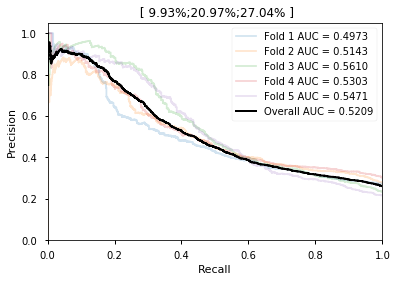

In [18]:
# We look at the PR curve
opt_learning_rate = res['best']['best_args']['learning_rate']
opt_n_est = res['best']['best_args']['n_estimators']
fig, ax = plt.subplots()
evaluate_recall_for_precision(ax, estimator(res['best']['best_args']), x, y, dates,'',prec_thresh_list=[0.9,0.8,0.7])

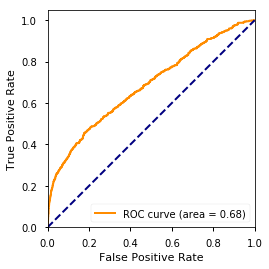

In [19]:
# And the roc curve
fig, ax = plt.subplots()
train_i,test_i = distinct_date_split(x,y,dates)[0]
x_train, x_test,y_train, y_test = x[train_i], x[test_i], y[train_i], y[test_i]
clf = estimator(res['best']['best_args'])
clf.fit(x_train,y_train)
y_proba_sick = clf.predict_proba(x_test)[:,1]
draw_roc(ax,y_test,y_proba_sick,'',0.2)
fig.show()

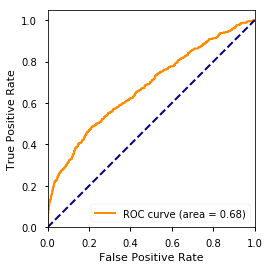

In [20]:
#and with balanced classes
fig, ax = plt.subplots()
x_b,y_b = get_balanced_classes(x_test,y_test)
y_proba_sick = clf.predict_proba(x_b)[:,1]
draw_roc(ax,y_b,y_proba_sick,'',0.2)
fig.show()

# Tuning tree based parameters
Following the advices given [here](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) we will use the previously determined optimal Boosting parameters to grid search for the tree specific parameters in the following order:
1. Tune max_depth (typically between 2 and 10) and num_samples_split (typically ~0.5-1% of total values)
2. Tune min_samples_leaf
3. Tune max_features

In [27]:
params = {'learning_rate': [opt_learning_rate], 'n_estimators': [opt_n_est], 
             'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

estimator = lambda kw_args: make_pipeline(sklearn.preprocessing.Imputer(strategy='mean'),
                                          preprocessing.StandardScaler(),
                                          sklearn.ensemble.GradientBoostingClassifier(**kw_args))

res = custom_GridSearchCV(x,y,dates,estimator,params,cv=5)

{'learning_rate': 0.050000000000000003, 'max_depth': 5, 'min_samples_split': 200, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 5, 'min_samples_split': 400, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 5, 'min_samples_split': 600, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 5, 'min_samples_split': 800, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 5, 'min_samples_split': 1000, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 7, 'min_samples_split': 200, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 7, 'min_samples_split': 400, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 7, 'min_samples_split': 600, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 7, 'min_samples_split': 800, 'n_estimators': 100}
{'learning_rate': 0.050000000000000003, 'max_depth': 7, 'min_samples_spl

In [28]:
res

{'best': {'best_args': {'learning_rate': 0.050000000000000003,
   'max_depth': 11,
   'min_samples_split': 600,
   'n_estimators': 100},
  'best_auc': 0.53159561841196967},
 'results': {"{'learning_rate': 0.050000000000000003, 'max_depth': 11, 'min_samples_split': 1000, 'n_estimators': 100}": {'mean_auc': 0.52471148438300652,
   'std_auc': 0.024027908482282843},
  "{'learning_rate': 0.050000000000000003, 'max_depth': 11, 'min_samples_split': 200, 'n_estimators': 100}": {'mean_auc': 0.51914102295432563,
   'std_auc': 0.023683004105381197},
  "{'learning_rate': 0.050000000000000003, 'max_depth': 11, 'min_samples_split': 400, 'n_estimators': 100}": {'mean_auc': 0.52465197610858705,
   'std_auc': 0.026613837060357599},
  "{'learning_rate': 0.050000000000000003, 'max_depth': 11, 'min_samples_split': 600, 'n_estimators': 100}": {'mean_auc': 0.53159561841196967,
   'std_auc': 0.025533301635958381},
  "{'learning_rate': 0.050000000000000003, 'max_depth': 11, 'min_samples_split': 800, 'n_estima

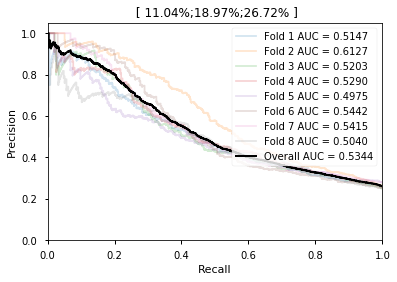

In [30]:
# We look at the PR curve
opt_learning_rate = res['best']['best_args']['learning_rate']
opt_n_est = res['best']['best_args']['n_estimators']
fig, ax = plt.subplots()
evaluate_recall_for_precision(ax, estimator(res['best']['best_args']), x, y, dates,'',prec_thresh_list=[0.9,0.8,0.7],cv=8)

In [5]:
def get_sick_label(x):
    if(x in ['internet.noconnection.start','internet.interruption.start','internet.performance.start']):
        return 1
    else:
        return 0

y_modified = y_extracted.map(get_sick_label) 

In [1]:
estimator = lambda kw_args: make_pipeline(sklearn.preprocessing.Imputer(strategy='mean'),
                                          preprocessing.StandardScaler(),
                                          sklearn.ensemble.GradientBoostingClassifier(**kw_args))
best_args = {'learning_rate': 0.050000000000000003,
   'max_depth': 11,
   'min_samples_split': 600,
   'n_estimators': 100}
fig, ax = plt.subplots()
evaluate_recall_for_precision(ax, estimator(best_args), x, y, dates,'',prec_thresh_list=[0.9,0.8,0.7],cv=5)

NameError: name 'plt' is not defined